In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os ; import re

In [ ]:
npnts = 10001
nvib = 36
nJ = 81

#-------------------------------------------------------------------------------#
# EXTRAER AUTOFUNCIONES VIBRACIONALES
#-------------------------------------------------------------------------------#
def is_head_eigenvib(line:str) -> bool:
    """
    Detecta la linea que marca el comienzo de 
    una nueva autofunción de un nivel vibracional
    Formato: 1 0.0000 1 0 X 3Sigmam -> 
    -------> Indice Energia Estado NVib Nombre Estado
    """

    s = line.strip()
    if not s:
        return False
    
    parts = s.split()
    #Si no tiene más de 2 campos
    if len(parts) < 2:
        return False
    
    #POR SI ACASOS
    #Si el primer campo no es un entero
    if not re.fullmatch(r"[+-]?\d+", parts[0]):
        return False
    
    #Si el segundo campo no es un valor decimal
    if not re.fullmatch(r"[+-]?(\d+(\.\d*)?|\.\d+)([Ee][+-]?\d+)?", parts[1]):
        return False
    
    return True

#-------------------------------------------------------------------------------#
#Parsing Vibrational Eigenfunctions
#-------------------------------------------------------------------------------#

def parse_duo_vib_einfun(fname:str, npoints: int, nvib: int):
    """
    Parsea el archivo de autofunciones de vibración de DUO
    """
    f = open(fname, 'r')
    lines = f.readlines()

    vibmat = np.zeros((npoints,nvib))
    evect = np.zeros((nvib))
    ncurrpoint = 0 ; ncurrvib = 0
    for i,line in enumerate(lines):
        if is_head_eigenvib(line):
            ncurrpoint = 0
            ncurrvib = int(line.split()[3])
            evect[ncurrvib] = float(line.split()[1])
        elif "End of contracted basis" in line:
            break
        else:
            vibmat[ncurrpoint,ncurrvib] = float(line)
            ncurrpoint += 1

    return vibmat

#-------------------------------------------------------------------------------#
# Reading Dyson Matrix
#-------------------------------------------------------------------------------#

def dyson_mat(fname:str):
    dysvals = np.loadtxt(fname, dtype=np.float64)
    rvals = dysvals[:,0]; dys_N_C1 = dysvals[:,1] ; dys_N_C2 = dysvals[:,2]
    dysmat_N_C1 = np.zeros((dysvals.shape[0],dysvals.shape[0]))
    dysmat_N_C2 = np.zeros((dysvals.shape[0],dysvals.shape[0]))

    for i in range(dysvals.shape[0]):
            dysmat_N_C1[i][i] = dys_N_C1[i]*0.393456
            dysmat_N_C2[i][i] = dys_N_C2[i]*0.393456

    return rvals,dysmat_N_C1, dysmat_N_C2

def bra_ket(vib_ini, vib_fin, dymat):
    
    intensity = (vib_fin.T @ (dymat @ vib_ini))
    return intensity

#-------------------------------------------------------------------------------#
# Reading Energy as a function of J
#-------------------------------------------------------------------------------#

def getJvals(fname:str, nvib: int, nj: int, mult: int):
    f = open(fname, 'r')
    lines = f.readlines()

    jn = 0
    for i,line in enumerate(lines):
        if i == 0:
            Lambda_abs = abs(int(float(line.split()[5])))
            if Lambda_abs == 0:
                nOmega = mult
            else:
                nOmega = (Lambda_abs+1) * mult
            Jvals = np.zeros((nvib,nj,nOmega))

        parts = line.split()
        vibn = int(parts[4])
        jn = int(round(float(parts[0])))

        #Getting indexes for J projections
        S=(mult-1)/2
        mval = float(parts[8])
        midx = int(round(mval+S))
        
        if vibn < nvib:
            Jvals[vibn,jn,midx] = float(parts[2])
        else:
            continue

    return Jvals,nOmega

#-------------------------------------------------------------------------------#
#Reading rovib coeffs 
#-------------------------------------------------------------------------------#

def getcoefvals(fname:str,nvib:int,nj:int,nom:int,mult:int):
    data = np.loadtxt(fname,skiprows=9) ; data = data[:-1]

    coeffs = np.zeros((nvib,nj,nom))
    for i in range(data.shape[0]):
        vibn = int(data[i][5])
        jn = int(round(float(data[i][1])))
        S=(mult-1)/2
        mval = float(data[i][9])
        midx = int(round(mval+S))
        coeffs[vibn,jn,midx] = data[i][3]
    return coeffs

#-------------------------------------------------------------------------------#
# Making the intensity matrix
#-------------------------------------------------------------------------------#

def make_int_byE(PHener,PHMener,dysmat,PHvibs,PHMvibs,maskRvals,
                OmegaPH,OmegaPHM,ZPEPH,ZPEPHM,PHsttsE,PHMsttsE,
                numvibPH:int,numvibPHM:int,
                numJPH:int,numJPHM:int):

    """
    Make the intensity matrix
    """
    Eh_to_cm = 219474.6
    dysmat = dysmat[maskRvals] ; dysmat = dysmat[:,maskRvals]
    relInt = np.zeros((numvibPH,numvibPHM,numJPH,numJPHM))
    evals = np.zeros((numvibPH,numvibPHM,numJPH,numJPHM))

    for i in range(numvibPH):
        for j in range(numvibPHM):
            PHvibsvn = PHvibs[:,i] ; PHvibsvn = PHvibsvn[mask]
            PHMvibsvn = PHMvibs[:,j] ; PHMvibsvn = PHMvibsvn[mask]
            bk_val = bra_ket(PHvibsvn,PHMvibsvn,dysmat)
            for k in range(numJPH):
                PHsumOmega = (np.average(PHener[i,k,:]+ZPEPH)/Eh_to_cm)+PHsttsE
                degJi = 2*k+1
                for l in range(numJPHM):
                    PHMsumOmega = ((np.average(PHMener[j,l,:])+ZPEPHM)/Eh_to_cm)+PHMsttsE
                    diff = abs(PHsumOmega - PHMsumOmega)
                    relInt[i,j,k,l] = degJi*diff*abs(bk_val)**2
                    relInt[i,j,k,l] = diff*abs(bk_val)**2
                    evals[i,j,k,l] = diff

    return evals,relInt

#-------------------------------------------------------------------------------#
# Get normalization factor Q(T)
#-------------------------------------------------------------------------------#

def get_norm_factor(T,Jener,ZPE,Estt,numvib:int,numJ:int):

    Eh_to_cm = 219474.6 ; kb = 3.166811563*10**-6
    normf = np.zeros(numvib)
    for i in range(numvib):
        for j in range(numJ):
            sumOm = (np.average(Jener[i,j,:]+ZPE)/Eh_to_cm)+Estt
            sumOm = sumOm - ((np.average(Jener[i,0,:])/Eh_to_cm)+Estt)
            normf[i] += (2*j+1)*np.exp(-sumOm/(kb*T))

    return normf

#-------------------------------------------------------------------------------#
#Make intensity matrix including the boltzmann distribution of J vals
#-------------------------------------------------------------------------------#

def make_int_byE_Boltzdist(PHener,PHMener,dysmat,PHvibs,PHMvibs,maskRvals,Temp,
                OmegaPH,OmegaPHM,ZPEPH,ZPEPHM,PHsttsE,PHMsttsE,
                numvibPH:int,numvibPHM:int,
                numJPH:int,numJPHM:int):

    """
    Make the intensity matrix
    """
    Eh_to_cm = 219474.6
    dysmat = dysmat[maskRvals] ; dysmat = dysmat[:,maskRvals]
    relInt = np.zeros((numvibPH,numvibPHM,numJPH,numJPHM))
    evals = np.zeros((numvibPH,numvibPHM,numJPH,numJPHM))

    normfPH = get_norm_factor(Temp,PHener,ZPEPH,PHsttsE,numvibPH,numJPH)
    normfPHM = get_norm_factor(Temp,PHMener,ZPEPHM,PHMsttsE,numvibPHM,numJPHM)

    for i in range(numvibPH):
        for j in range(numvibPHM):
            PHvibsvn = PHvibs[:,i] ; PHvibsvn = PHvibsvn[mask]
            PHMvibsvn = PHMvibs[:,j] ; PHMvibsvn = PHMvibsvn[mask]
            bk_val = bra_ket(PHvibsvn,PHMvibsvn,dysmat)
            for k in range(numJPH):
                PHsumOmega = (np.average(PHener[i,k,:]+ZPEPH)/Eh_to_cm)+PHsttsE
                eboltz = PHsumOmega - ((np.average(PHener[i,0,:]+ZPEPH)/Eh_to_cm)+PHsttsE)
                degJi = ((2*k+1)*np.exp(-eboltz/(3.166811563*10**-6*Temp)))/normfPH[i]
                for l in range(numJPHM):
                    PHMsumOmega = ((np.average(PHMener[j,l,:])+ZPEPHM)/Eh_to_cm)+PHMsttsE
                    eboltz = PHMsumOmega - (((np.average(PHMener[j,0,:])+ZPEPHM)/Eh_to_cm)+PHMsttsE)
                    degJj = ((2*l+1)*np.exp(-eboltz/(3.166811563*10**(-6)*Temp)))/normfPHM[j]
                    diff = abs(PHsumOmega - PHMsumOmega)
                    relInt[i,j,k,l] = degJi*degJj*diff*abs(bk_val)**2
                    relInt[i,j,k,l] = degJi*diff*abs(bk_val)**2
                    # relInt[i,j,k,l] = diff*abs(bk_val)**2
                    evals[i,j,k,l] = diff

    return evals,relInt

#-------------------------------------------------------------------------------#
# Get normalization factor Q(T) complete rovibrational levels
#-------------------------------------------------------------------------------#

def rovib_normf(T, Jener, ZPE, Estt, numvib:int, numJ:int):

    Eh_to_cm = 219474.6
    kb = 3.166811563e-6  # Eh/K

    # calcular Emin global coherente
    Emin = 1e99
    for i in range(numvib):
        for j in range(numJ):
            Ei = ((np.average(Jener[i,j,:]) + ZPE)/Eh_to_cm) + Estt
            if Ei < Emin:
                Emin = Ei

    # construir Q(T)
    Q = 0.0
    for i in range(numvib):
        for j in range(numJ):
            Ei = ((np.average(Jener[i,j,:]) + ZPE)/Eh_to_cm) + Estt
            Ei_rel = Ei - Emin
            Q += (2*j+1) * np.exp(-Ei_rel/(kb*T))

    return Q

#-------------------------------------------------------------------------------#
#Make intensity matrix including the boltzmann distribution of J vals
#-------------------------------------------------------------------------------#

def intBE_RovibBdist(PHener,PHMener,dysmat,PHvibs,PHMvibs,maskRvals,Temp,
                OmegaPH,OmegaPHM,ZPEPH,ZPEPHM,PHsttsE,PHMsttsE,
                numvibPH:int,numvibPHM:int,
                numJPH:int,numJPHM:int):

    """
    Make the intensity matrix
    """
    Eh_to_cm = 219474.6
    dysmat = dysmat[maskRvals] ; dysmat = dysmat[:,maskRvals]
    relInt = np.zeros((numvibPH,numvibPHM,numJPH,numJPHM))
    evals = np.zeros((numvibPH,numvibPHM,numJPH,numJPHM))

    normfPH = rovib_normf(Temp,PHener,ZPEPH,PHsttsE,numvibPH,numJPH)
    normfPHM = rovib_normf(Temp,PHMener,ZPEPHM,PHMsttsE,numvibPHM,numJPHM)

    for i in range(numvibPH):
        for j in range(numvibPHM):
            PHvibsvn = PHvibs[:,i] ; PHvibsvn = PHvibsvn[mask]
            PHMvibsvn = PHMvibs[:,j] ; PHMvibsvn = PHMvibsvn[mask]
            bk_val = bra_ket(PHvibsvn,PHMvibsvn,dysmat)
            for k in range(numJPH):
                PHsumOmega = (np.average(PHener[i,k,:]+ZPEPH)/Eh_to_cm)
                eboltz = PHsumOmega - ((np.min(PHener[:,:,:]) + ZPEPH)/Eh_to_cm)
                degJi = ((2*k+1)*np.exp(-eboltz/(3.166811563*10**(-6)*Temp)))/normfPH
                PHsumOmega += PHsttsE
                for l in range(numJPHM):
                    PHMsumOmega = ((np.average(PHMener[j,l,:])+ZPEPHM)/Eh_to_cm)
                    eboltz = PHMsumOmega - (((np.min(PHMener[:,:,:])+ZPEPHM)/Eh_to_cm))
                    PHMsumOmega += PHMsttsE
                    degJj = ((2*l+1)*np.exp(-eboltz/(3.166811563*10**(-6)*Temp)))/normfPHM
                    diff = abs(PHsumOmega - PHMsumOmega)
                    # relInt[i,j,k,l] = degJj*degJi*diff*abs(bk_val)**2
                    relInt[i,j,k,l] = degJi*diff*abs(bk_val)**2
                    evals[i,j,k,l] = diff

    return evals,relInt

#-------------------------------------------------------------------------------#
#Honl-London factors
#-------------------------------------------------------------------------------#

def honl_london_factors(Ji,dJ):
    """
    Calculate Honl-London factors
    """
    den = 2*Ji + 1
    if dJ == -1: 
        return Ji/den if Ji > 0 else 0.0
    if dJ == 0:
        return 1.0/den
    if dJ == 1:
        return (Ji+1)/den

    return 0.0

#-------------------------------------------------------------------------------#
#Make intensity matrix with HL factors and DJ values
#-------------------------------------------------------------------------------#

def intBE_DJ_HL(PHener,PHMener,dysmat,PHvibs,PHMvibs,maskRvals,Temp,
                OmegaPH,OmegaPHM,ZPEPH,ZPEPHM,PHsttsE,PHMsttsE,DJ:int,
                numvibPH:int,numvibPHM:int,
                numJPH:int,numJPHM:int):

    """
    Make the intensity matrix
    """
    Eh_to_cm = 219474.6
    dysmat = dysmat[maskRvals] ; dysmat = dysmat[:,maskRvals]
    relInt = np.zeros((numvibPH,numvibPHM,numJPH,numJPHM))
    evals = np.zeros((numvibPH,numvibPHM,numJPH,numJPHM))

    normfPH = rovib_normf(Temp,PHener,ZPEPH,PHsttsE,numvibPH,numJPH)
    normfPHM = rovib_normf(Temp,PHMener,ZPEPHM,PHMsttsE,numvibPHM,numJPHM)

    djlist = []
    for i in range(-DJ,DJ+1,1):
        djlist.append(i)
    
    for i in range(numvibPH):
        for j in range(numvibPHM):
            PHvibsvn = PHvibs[:,i] ; PHvibsvn = PHvibsvn[mask]
            PHMvibsvn = PHMvibs[:,j] ; PHMvibsvn = PHMvibsvn[mask]
            bk_val = bra_ket(PHvibsvn,PHMvibsvn,dysmat)
            for k in range(numJPH):
                PHsumOmega = (np.average(PHener[i,k,:]+ZPEPH)/Eh_to_cm)
                eboltz = PHsumOmega - ((np.min(PHener[:,:,:]) + ZPEPH)/Eh_to_cm)
                degJi = ((2*k+1)*np.exp(-eboltz/(3.166811563*10**(-6)*Temp)))/normfPH
                PHsumOmega += PHsttsE
                for l in range(numJPHM):
                    djval = l - k
                    if DJ == 1 and djval in djlist:
                        hlfact = honl_london_factors(k,djval)
                    else:
                        hlfact = 0.0
                    PHMsumOmega = ((np.average(PHMener[j,l,:])+ZPEPHM)/Eh_to_cm)
                    eboltz = PHMsumOmega - (((np.min(PHMener[:,:,:])+ZPEPHM)/Eh_to_cm))
                    PHMsumOmega += PHMsttsE
                    degJj = ((2*l+1)*np.exp(-eboltz/(3.166811563*10**(-6)*Temp)))/normfPHM
                    diff = abs(PHsumOmega - PHMsumOmega)
                    relInt[i,j,k,l] = degJi*hlfact*diff*abs(bk_val)**2
                    relInt[i,j,k,l] = degJi*hlfact*abs(bk_val)**2
                    evals[i,j,k,l] = diff

    return evals,relInt

#-------------------------------------------------------------------------------#
# Get normalization factor Q(T) complete rovibrational levels including Projs
#-------------------------------------------------------------------------------#

def rovibOm_normf(T, Jener, ZPE, Estt, numvib:int, numJ:int, Projs:int):

    Eh_to_cm = 219474.6
    kb = 3.166811563e-6  # Eh/K

    # calcular Emin global coherente
    Emin = 1e99
    for i in range(numvib):
        for j in range(numJ):
            for k in range(Projs):
                Ei = (Jener[i,j,k] + ZPE)/Eh_to_cm + Estt
                if Ei < Emin:
                    Emin = Ei

    # construir Q(T)
    Q = 0.0
    for i in range(numvib):
        for j in range(numJ):
            for k in range(Projs):
                Ei = (Jener[i,j,k] + ZPE)/Eh_to_cm + Estt
                Ei_rel = Ei - Emin
                Q += (2*j+1) * np.exp(-Ei_rel/(kb*T))

    return Q

#-------------------------------------------------------------------------------#
#Make intensity matrix including Omega values
#-------------------------------------------------------------------------------#

def int_Omdist(PHener,PHMener,dysmat,PHvibs,PHMvibs,maskRvals,Temp,
                ZPEPH,ZPEPHM,PHsttsE,PHMsttsE,DJ:int,
                numvibPH:int,numvibPHM:int,numJPH:int,numJPHM:int,
                numOmPH:int,numOmPHM:int):

    """
    Make the intensity matrix
    """
    Eh_to_cm = 219474.6
    dysmat = dysmat[maskRvals] ; dysmat = dysmat[:,maskRvals]
    relInt = np.zeros((numvibPH,numvibPHM,numJPH,numJPHM,numOmPH,numOmPHM))
    evals = np.zeros((numvibPH,numvibPHM,numJPH,numJPHM,numOmPH,numOmPHM))

    normfPH = rovibOm_normf(Temp,PHener,ZPEPH,PHsttsE,numvibPH,numJPH,numOmPH)
    normfPHM = rovibOm_normf(Temp,PHMener,ZPEPHM,PHMsttsE,numvibPHM,numJPHM,numOmPHM)

    djlist = []
    for i in range(-DJ,DJ+1,1):
        djlist.append(i)
    
    for i in range(numvibPH):
        for j in range(numvibPHM):

            PHvibsvn = PHvibs[:,i] ; PHvibsvn = PHvibsvn[mask]
            PHMvibsvn = PHMvibs[:,j] ; PHMvibsvn = PHMvibsvn[mask]
            bk_val = bra_ket(PHvibsvn,PHMvibsvn,dysmat)

            for k in range(numJPH):
                for l in range(numJPHM):
                    
                    djval = l - k
                    if DJ == 1 and djval in djlist:
                        hlfact = honl_london_factors(k,djval)
                    else:
                        hlfact = 0.0

                    for m in range(numOmPH):
                        PHsumOmega = (PHener[i,k,m]+ZPEPH)/Eh_to_cm
                        eboltz = PHsumOmega - ((np.min(PHener[:,:,:]) + ZPEPH)/Eh_to_cm)
                        degJi = ((2*k+1)*np.exp(-eboltz/(3.166811563*10**(-6)*Temp)))/normfPH
                        PHsumOmega += PHsttsE
                        for n in range(numOmPHM):

                            PHMsumOmega = (np.average(PHMener[j,l,n])+ZPEPHM)/Eh_to_cm
                            eboltz = PHMsumOmega - (((np.min(PHMener[:,:,:])+ZPEPHM)/Eh_to_cm))
                            PHMsumOmega += PHMsttsE

                            diff = abs(PHsumOmega - PHMsumOmega)

                            relInt[i,j,k,l,m,n] = degJi*hlfact*diff*abs(bk_val)**2
                            relInt[i,j,k,l,m,n] = degJi*hlfact*abs(bk_val)**2
                            evals[i,j,k,l,m,n] = diff

    return evals,relInt

#-------------------------------------------------------------------------------#
#BraKet for all vibrational states
#-------------------------------------------------------------------------------#

def bra_ket_comp(vibPH, vibPHM, dymat):
    
    int_by_vib = np.zeros((len(vibPH),len(vibPHM)))
    for i in range(len(vibPH)):
        vib_ini = vibPH[i]
        for j in range(len(vibPHM)):
            vib_fin = vibPHM[j]
            int_by_vib[i,j] = (vib_fin.T @ (dymat @ vib_ini))
    return int_by_vib

#-------------------------------------------------------------------------------#
#Make intensity matrix including Omega values with Coeffs
#-------------------------------------------------------------------------------#

def int_Coeffs(PHener,PHMener,dysmat,PHvibs,PHMvibs,CoeffsPH,CoeffsPHM,
                maskRvals,Temp,ZPEPH,ZPEPHM,PHsttsE,PHMsttsE,DJ:int,
                numvibPH:int,numvibPHM:int,numJPH:int,numJPHM:int,
                numOmPH:int,numOmPHM:int):

    """
    Make the intensity matrix
    """
    Eh_to_cm = 219474.6
    dysmat = dysmat[maskRvals] ; dysmat = dysmat[:,maskRvals]
    relInt = np.zeros((numvibPH,numvibPHM,numJPH,numJPHM,numOmPH,numOmPHM))
    evals = np.zeros((numvibPH,numvibPHM,numJPH,numJPHM,numOmPH,numOmPHM))

    normfPH = rovibOm_normf(Temp,PHener,ZPEPH,PHsttsE,numvibPH,numJPH,numOmPH)
    normfPHM = rovibOm_normf(Temp,PHMener,ZPEPHM,PHMsttsE,numvibPHM,numJPHM,numOmPHM)

    djlist = []
    for i in range(-DJ,DJ+1,1):
        djlist.append(i)
    
    for i in range(numvibPH):
        for j in range(numvibPHM):

            PHvibsvn = PHvibs[:,i] ; PHvibsvn = PHvibsvn[mask]
            PHMvibsvn = PHMvibs[:,j] ; PHMvibsvn = PHMvibsvn[mask]
            bk_val = bra_ket(PHvibsvn,PHMvibsvn,dysmat)

            for k in range(numJPH):
                for l in range(numJPHM):
                    
                    djval = l - k
                    if DJ == 1 and djval in djlist:
                        hlfact = honl_london_factors(k,djval)
                    else:
                        hlfact = 0.0

                    for m in range(numOmPH):
                        cPH = CoeffsPH[i,k,m]

                        PHsumOmega = (PHener[i,k,m]+ZPEPH)/Eh_to_cm
                        eboltz = PHsumOmega - ((np.min(PHener[:,:,:]) + ZPEPH)/Eh_to_cm)
                        degJi = ((2*k+1)*np.exp(-eboltz/(3.166811563*10**(-6)*Temp)))/normfPH
                        PHsumOmega += PHsttsE

                        for n in range(numOmPHM):
                            cPHM = CoeffsPHM[j,l,n]

                            PHMsumOmega = (np.average(PHMener[j,l,n])+ZPEPHM)/Eh_to_cm
                            eboltz = PHMsumOmega - (((np.min(PHMener[:,:,:])+ZPEPHM)/Eh_to_cm))
                            PHMsumOmega += PHMsttsE

                            diff = abs(PHsumOmega - PHMsumOmega)

                            # relInt[i,j,k,l,m,n] = degJi*hlfact*diff*abs(bk_val)**2
                            relInt[i,j,k,l,m,n] = degJi*hlfact*abs(bk_val)**2
                            evals[i,j,k,l,m,n] = diff

    return evals,relInt

#-------------------------------------------------------------------------------#
PHGSEtotal = -341.4992406252  ; ZPEPH = 1187.278444217386
PHMGSEtotal = -341.1257312537 ; ZPEPHMGS = 1177.879470966726
PHMa4Etotal = -341.0637850085 ; ZPEPHMa4Sm = 912.380170536803
Temp=1000.0

pathor="/home/jorgebdelafuente/Doctorado/Photoion/DUO/PHPHM/"
PHvibs = parse_duo_vib_einfun(pathor+"PH/vibeigenvect_vib.chk", npnts, nvib)
PHMGSvibs = parse_duo_vib_einfun(pathor+"PHM_GS/vibeigenvect_vib.chk", npnts, nvib)
PHMa4Smvibs = parse_duo_vib_einfun(pathor+"PHM_a4Sm/vibeigenvect_vib.chk", npnts, nvib)

PHJener,nOmPH = getJvals(pathor+"PH/rovibronic_energies.dat", nvib, nJ, 3)
PHMGSJener,nOmPHGS = getJvals(pathor+"PHM_GS/rovibronic_energies.dat", nvib, nJ, 2)
PHMa4SmJener,nOmPHa4Sm= getJvals(pathor+"PHM_a4Sm/rovibronic_energies.dat", nvib, nJ, 4)

rvals,dysmat_N_C1,dysmat_N_C2 = dyson_mat(pathor+"Dipole_moment_functions.dat")
mask = (rvals > 0.793755) & (rvals < 1.8)

evals,relInt = int_Omdist(PHJener,PHMGSJener,dysmat_N_C1,PHvibs,PHMGSvibs,mask,Temp,ZPEPH,ZPEPHMGS,PHGSEtotal,PHMGSEtotal,
                        1,10,10,10,10,nOmPH,nOmPHGS)

0.019458587375249914


(10.0, 10.3)

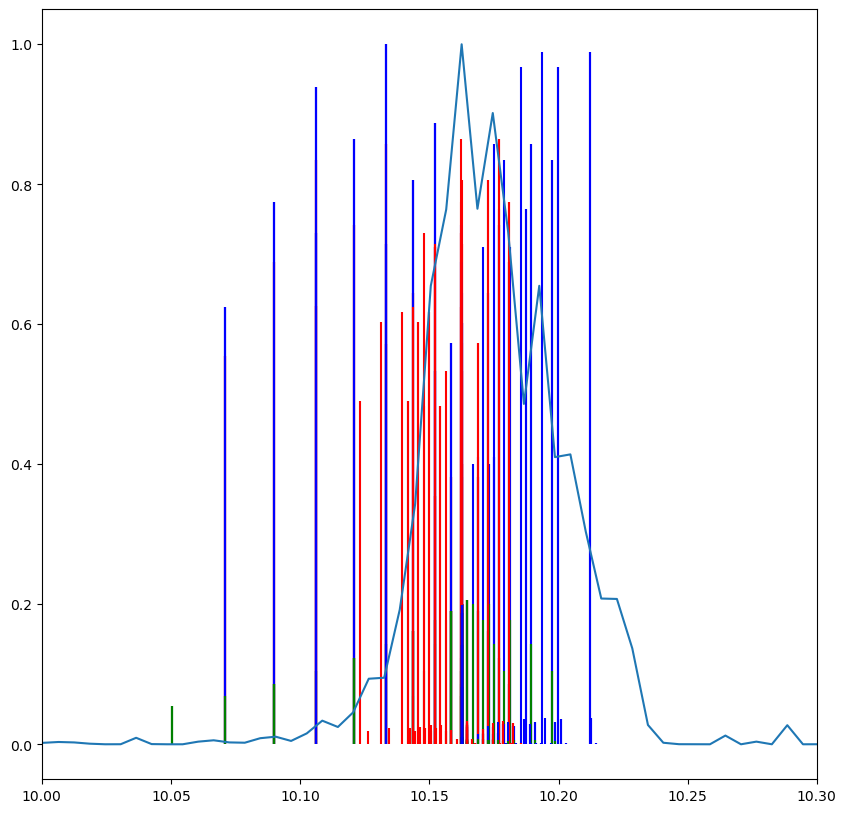

In [12]:
exp_esp = np.loadtxt("/home/jorgebdelafuente/Doctorado/Photoion/SHARC/TPES.dat",skiprows=3)
fig,ax = plt.subplots(figsize=(10,10))
maxval = np.max(exp_esp[:,2])
ax.plot(exp_esp[:,0],exp_esp[:,2]/maxval)
maxval = np.max(relInt[:,:,:,:,:,:])
print(maxval)

for i in range(5):
    for j in range(5):
        for k in range(10):
            less = 0
            for l in range(10):
                for m in range(3):
                    for n in range(3):
                        if abs(k-l) < 10:
                            if (l-k) == -1:
                                ax.vlines(evals[i,j,k,l,m,n]*27.2114,0,relInt[i,j,k,l,m,n]/maxval,color="red",zorder=-10)
                            elif (l-k) == 0:
                                ax.vlines(evals[i,j,k,l,m,n]*27.2114,0,relInt[i,j,k,l,m,n]/maxval,color="green",zorder=-10)
                            elif (l-k) == 1:
                                ax.vlines(evals[i,j,k,l,m,n]*27.2114,0,relInt[i,j,k,l,m,n]/maxval,color="blue",zorder=-10)
                            
                            # if relInt[i,j,k,l,m,n]/maxval > 1.0e-2:
                            #     ax.annotate(("("+str(i)+","+str(j)+"),("+str(k+1)+","+str(l+1)+")"),xy=(evals[i,j,k,l,m,n]*27.2114,relInt[i,j,k,l,m,n]/maxval))
                    # less += 0.05

ax.set_xlim(10.0,10.30)

10


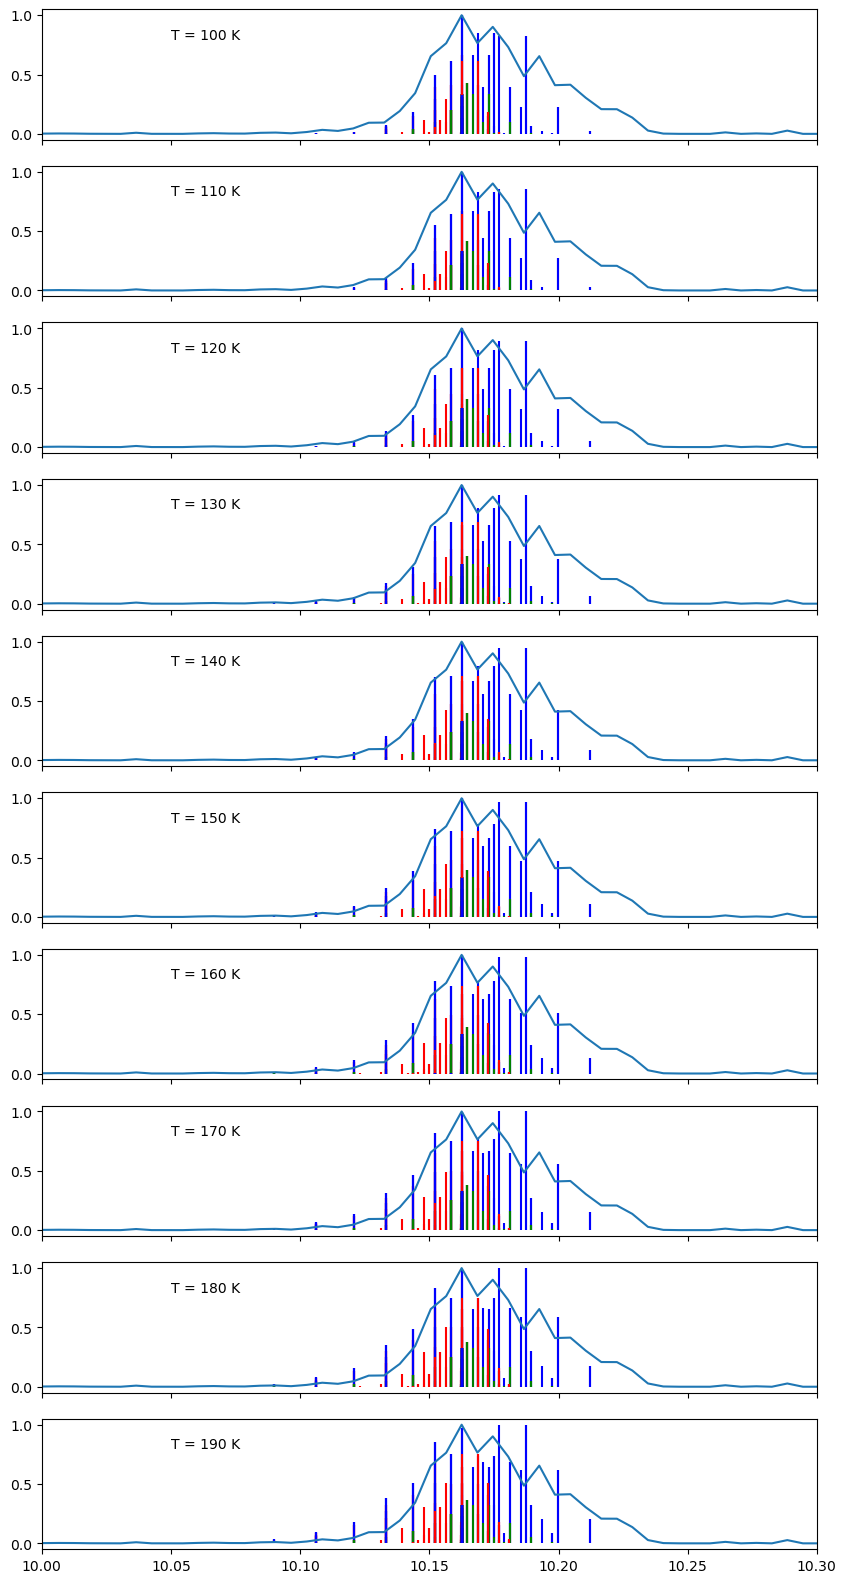

In [16]:
evals_temp = [] ; relInt_temp = [] ; temps = []
for T in range(100,200,10):
    if T == 0:
        continue
    evals,relInt = int_Omdist(PHJener,PHMGSJener,dysmat_N_C1,PHvibs,PHMGSvibs,mask,T,ZPEPH,ZPEPHMGS,PHGSEtotal,PHMGSEtotal,
                            1,10,10,10,10,nOmPH,nOmPHGS)
    evals_temp.append(evals)
    relInt_temp.append(relInt)
    temps.append(T)

fig2,ax2 = plt.subplots(len(temps),1,figsize=(10,20),sharex=True,sharey=True)
for p,T in enumerate(temps):
    eval = evals_temp[p] ; relInt = relInt_temp[p]
    maxval = np.max(exp_esp[:,2])
    ax2[p].plot(exp_esp[:,0],exp_esp[:,2]/maxval)
    maxval = np.max(relInt[:,:,:,:,:,:])
    for i in range(5):
        for j in range(5):
            for k in range(10):
                less = 0
                for l in range(10):
                    for m in range(3):
                        for n in range(3):
                            if abs(k-l) < 10:
                                if (l-k) == -1:
                                    ax2[p].vlines(eval[i,j,k,l,m,n]*27.2114,0,relInt[i,j,k,l,m,n]/maxval,color="red",zorder=-10)
                                elif (l-k) == 0:
                                    ax2[p].vlines(eval[i,j,k,l,m,n]*27.2114,0,relInt[i,j,k,l,m,n]/maxval,color="green",zorder=-10)
                                elif (l-k) == 1:
                                    ax2[p].vlines(eval[i,j,k,l,m,n]*27.2114,0,relInt[i,j,k,l,m,n]/maxval,color="blue",zorder=-10)
                                
    ax2[p].annotate("T = "+str(T)+" K",xy=(10.05,0.8),fontsize=10)
    ax2[p].set_xlim(10.0,10.30)
